In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import time
import numpy as np
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Download dataset from https://www.kaggle.com/datasets/datamunge/sign-language-mnist and update path

train_df = pd.read_csv('../../archive/sign_mnist_train.csv')
training_label = train_df[['label']]
test_df = pd.read_csv('../../archive/sign_mnist_test.csv')
test_label = test_df[['label']]

array([[<Axes: title={'center': 'label'}>]], dtype=object)

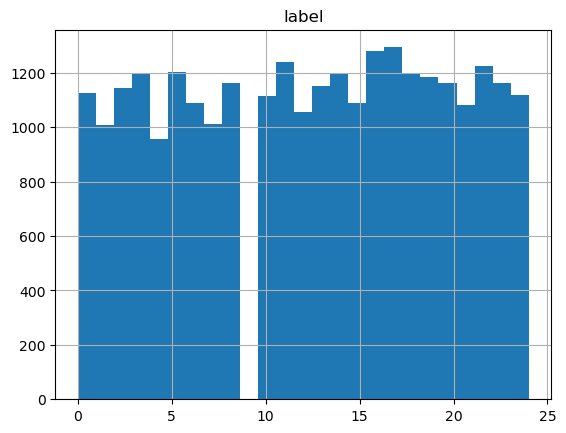

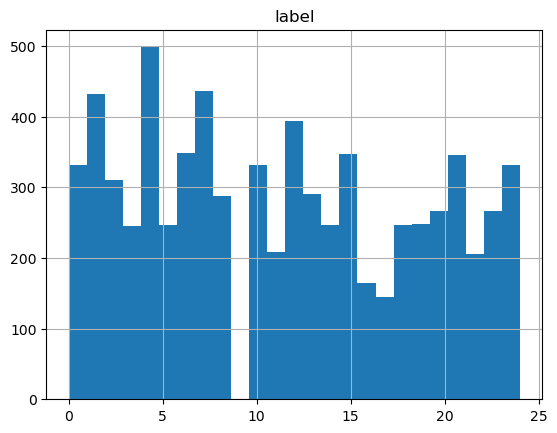

In [3]:
training_label.hist(column = 'label', bins=25)
test_label.hist(column = 'label', bins=25)

In [4]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [5]:
# Loading the .csv into the dataset

class SignLanguageDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df

        x = df.iloc[:, 1:].values.reshape(-1, 1, 28, 28)
        y = df.iloc[:, 0]

        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.x /= 255.0
        
    def shape(self):
        return self.x.shape

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [6]:
test_dataset = SignLanguageDataset(test_df)
print(test_dataset.shape())

training_dataset = SignLanguageDataset(train_df)
print(training_dataset.shape())

torch.Size([7172, 1, 28, 28])
torch.Size([27455, 1, 28, 28])


In [7]:
train_loader = DataLoader(training_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

torch.Size([24, 1, 28, 28])
    A      B      C      D      E      F      G      H      I      K      L      M      N      O      P      Q      R      S      T      U      V      W      X      Y


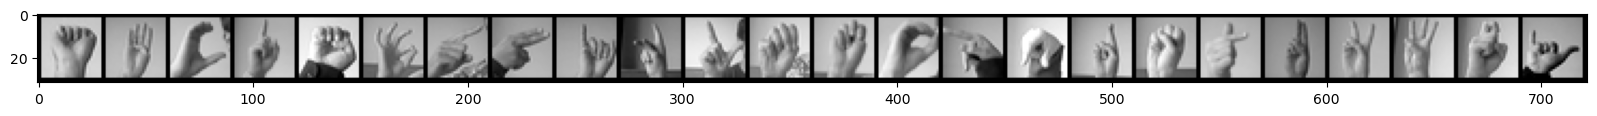

In [8]:
first_df = train_df.groupby('label', as_index=False).first()
first_dataset = SignLanguageDataset(first_df)

images, labels = first_dataset[:]
print(images.shape)

im = make_grid(images, nrow=len(first_df))
plt.figure(figsize=(20,8))
plt.imshow(np.transpose(im.numpy(),(1, 2, 0)))

labels_string = "      ".join([f"{class_names[int(label)]}" for label in labels])
print("    " + labels_string)

In [9]:
# Defining the network architecture

class SignLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=5*5*32, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=26)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, kernel_size=2, stride=2)
        X = X.view(-1, 5*5*32)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return F.log_softmax(input=self.fc3(X), dim=1)  

In [10]:
model = SignLanguageModel()
model


SignLanguageModel(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=26, bias=True)
)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training the model

start_time = time.time()
epochs = 30

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    tst_corr = 0
    trn_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/{len(train_df)}]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)

    # Test model per epoch
    model.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    model.train()

    loss = criterion(y_val,y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr)
    print(f'test accuracy: {tst_corr.item()*100/len(test_df):7.2f}%')
    torch.save(model.state_dict(), f"SignLanguageModel_Epoch_{i}.pt")
    
total_time = time.time() - start_time
print(f'\nDuration: {total_time:.0f} seconds')

epoch:  0  batch: 1000 [ 10000/27455]  loss: 0.82878208  accuracy:  34.620%
epoch:  0  batch: 2000 [ 20000/27455]  loss: 0.02118708  accuracy:  61.445%
test accuracy:   90.41%
epoch:  1  batch: 1000 [ 10000/27455]  loss: 0.00058562  accuracy:  98.400%
epoch:  1  batch: 2000 [ 20000/27455]  loss: 0.02318656  accuracy:  98.290%
test accuracy:   95.91%
epoch:  2  batch: 1000 [ 10000/27455]  loss: 0.00010969  accuracy: 100.000%
epoch:  2  batch: 2000 [ 20000/27455]  loss: 0.00004262  accuracy: 100.000%
test accuracy:   85.90%
epoch:  3  batch: 1000 [ 10000/27455]  loss: 0.00395598  accuracy:  97.880%
epoch:  3  batch: 2000 [ 20000/27455]  loss: 0.00007404  accuracy:  98.795%
test accuracy:   95.71%
epoch:  4  batch: 1000 [ 10000/27455]  loss: 0.00003265  accuracy: 100.000%
epoch:  4  batch: 2000 [ 20000/27455]  loss: 0.00000029  accuracy: 100.000%
test accuracy:   87.20%
epoch:  5  batch: 1000 [ 10000/27455]  loss: 0.00005215  accuracy:  98.600%
epoch:  5  batch: 2000 [ 20000/27455]  loss:

In [28]:
model.load_state_dict(torch.load("SignLanguageModel_Epoch_18.pt"))
model.eval()

test_load_all = DataLoader(test_dataset, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for b, (X_test, y_test) in enumerate(test_load_all):
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()
print(f'Test Accuracy: {correct.item()/len(test_df)*100:.2f}%')

Test Accuracy: 96.65%


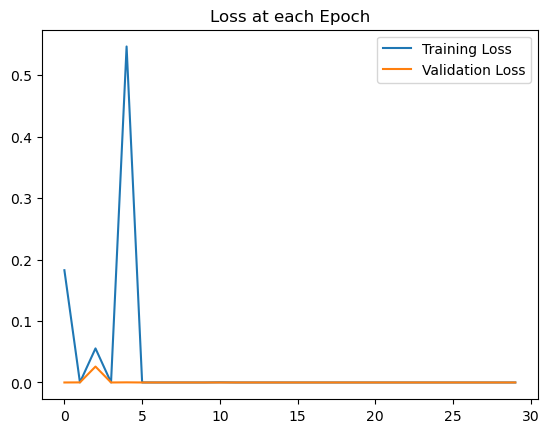

In [29]:
plt.plot(train_losses, label= 'Training Loss')
plt.plot(test_losses, label= 'Validation Loss')
plt.title('Loss at each Epoch')
plt.legend()

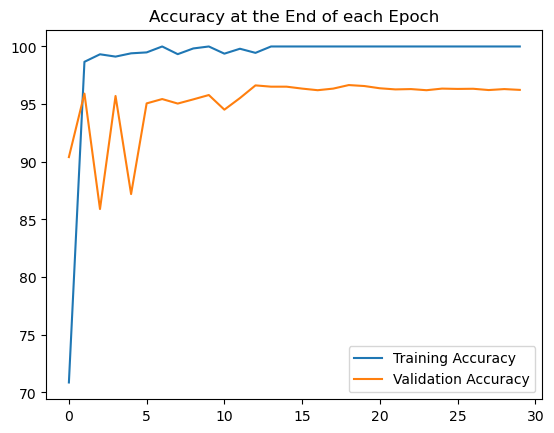

In [30]:
plt.plot([t/len(train_df)*100 for t in train_correct], label='Training Accuracy')
plt.plot([t/len(test_df)*100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the End of each Epoch')
plt.legend()


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
tensor([ 6,  5, 10,  ...,  2,  4,  2])


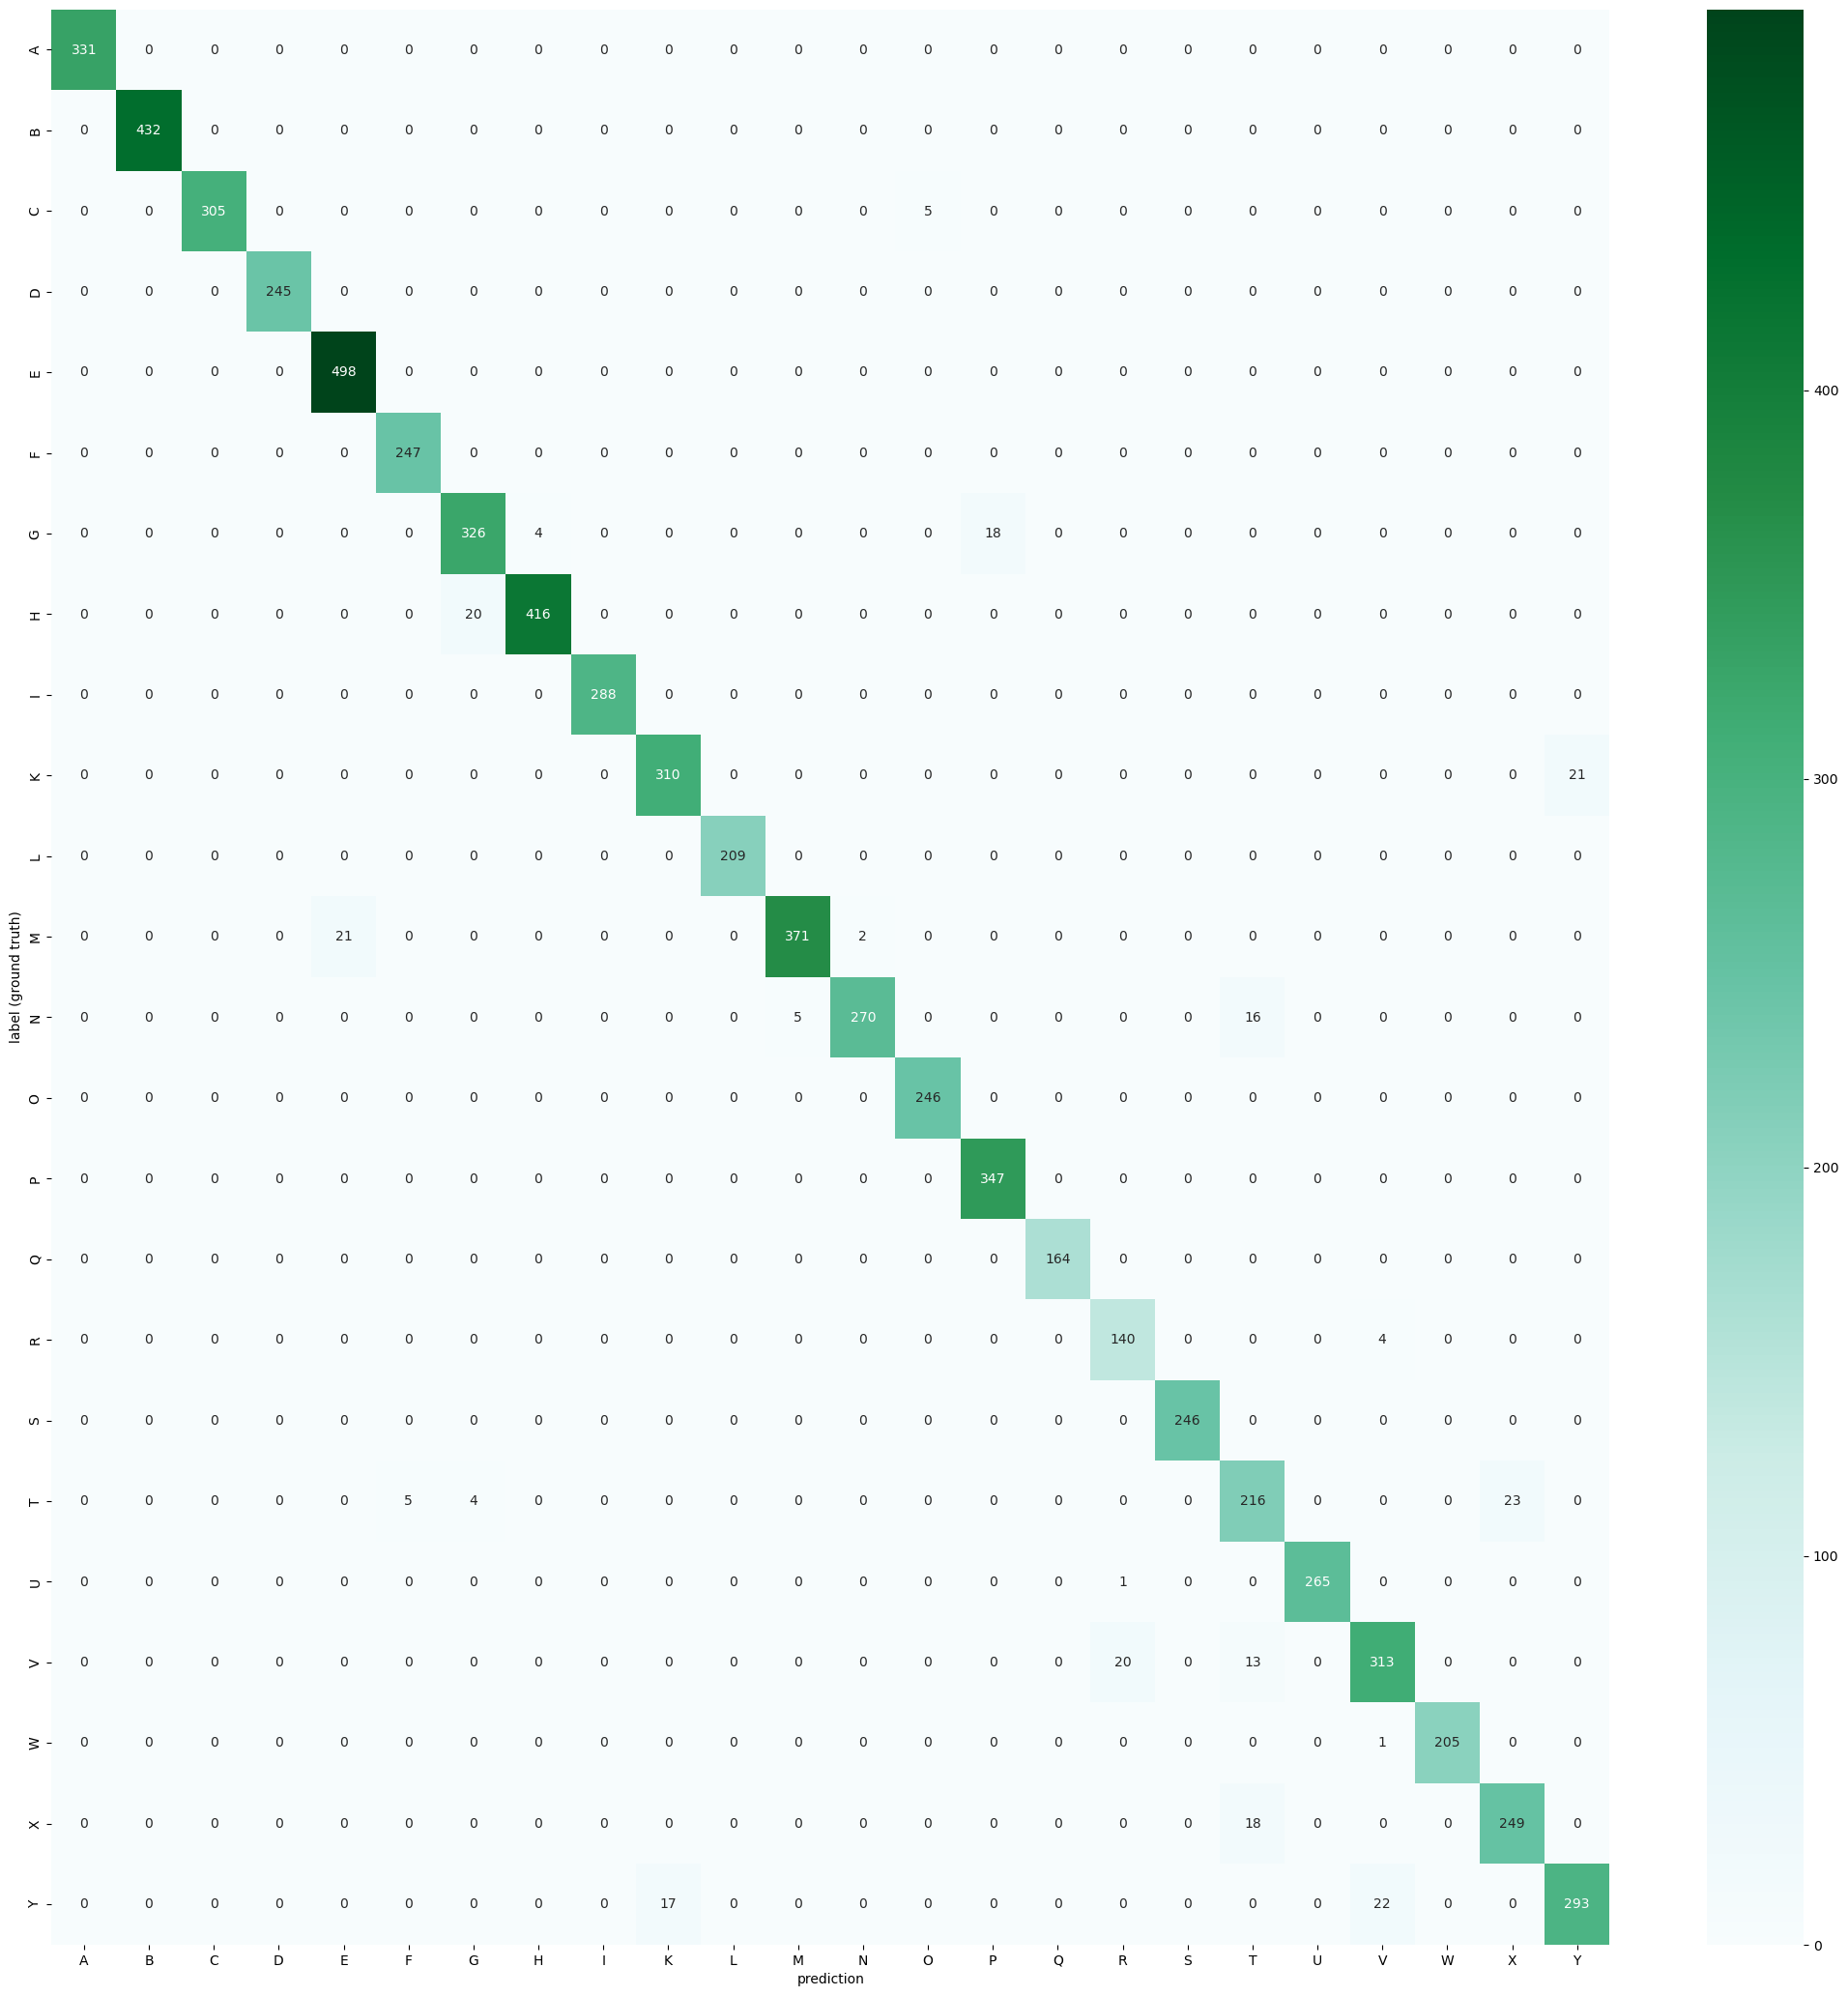

In [31]:
confusion_names = class_names.copy()
confusion_names.remove('J')
confusion_names.remove('Z')
print(confusion_names)
print(predicted)
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, confusion_names, confusion_names)
plt.figure(figsize = (26,26))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

Index: [  207   296   529  1053  1281  2168  2277  2791  3192  4112  4308  4876
  5313  5506  5650  6144  6168  6209  6329  6336  6375  6441  6804]
Label: [   19    19    19    19    19    19    19    19    19    19    19    19
    19    19    19    19    19    19    19    19    19    19    19]
Class:  T T T T T T T T T T T T T T T T T T T T T T T

Guess: [   23    23    23    23    23    23    23    23    23    23    23    23
    23    23    23    23    23    23    23    23    23    23    23]
Class:  X X X X X X X X X X X X X X X X X X X X X X X


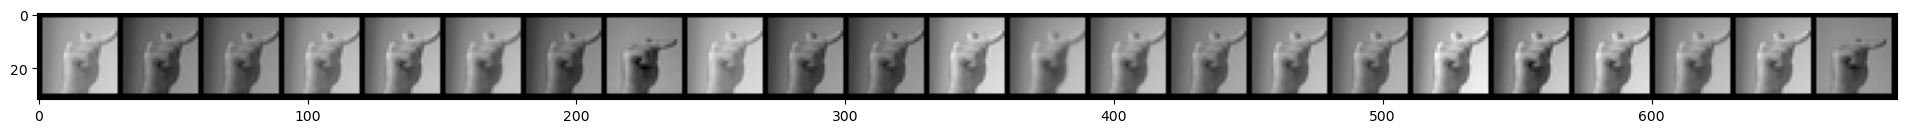

In [33]:
pred = class_names.index('X')
lbl = class_names.index('T')
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] == pred and y_test[i] == lbl:
        misses = np.append(misses,i).astype('int64')
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}'))
r = 24
row = iter(np.array_split(misses,len(misses)//r+1))
nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(24,24))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

